# Setup

Check requirements.txt ...

In [63]:
! pip install -r "requirements.txt"


[notice] A new release of pip available: 22.2.2 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


... and load packages

In [64]:
# Import of all packages used in this notebook
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pycountry
from pycountry_convert.convert_country_alpha2_to_continent_code \
    import country_alpha2_to_continent_code
from pycountry_convert.convert_continent_code_to_continent_name \
    import convert_continent_code_to_continent_name

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, make_union, Pipeline, FeatureUnion
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.metrics import PredictionErrorDisplay

from column_names import get_column_names
from utils.categoricalTransformer import CategoricalTransformer
from utils.numericalTransformer import NumericalTransformer

from scipy.stats.mstats import pearsonr


# Magic commands
%matplotlib inline
%load_ext pycodestyle_magic
# %pycodestyle_on

Download and unzip dataset, if necessary.

In [65]:
filename = 'cost-of-living_v2.csv'

# check if file already exists
if os.path.exists(filename):
    print('File {} exists.'.format(filename))

else:

    zip_file = 'global-cost-of-living.zip'

    # check if kaggle zip-file already exists
    if os.path.exists(zip_file):
        print('File {} exists.'.format(zip_file))
    else:
        # Download files from kaggle
        ! kaggle datasets download -d "mvieira101/global-cost-of-living"
    # end if

    # Unpacking files
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall('')
    print('Unpacking {}.'.format(zip_file))

# end if

16:37: E225 missing whitespace around operator


Import dataset

In [66]:
# import dataset
df = pd.read_csv(filename)

# give the columns informative names
df.columns = get_column_names()

global_random_state = 42

create fig-folder

In [67]:
if not os.path.isdir('fig'):
    os.mkdir('fig')

# Data Analysis

## Basics

Shape of the dataset

In [68]:
df.shape

(4956, 58)

Let's look at the column names.

In [69]:
df.columns

Index(['city', 'country', 'meal_cheap', 'meal_3_course', 'mc_meal',
       'beer_domestic_restaurant', 'beer_imported_restaurant',
       'capuccino_restaurant', 'coke_restaurant', 'water_restaurant', 'milk',
       'bread', 'rice', 'eggs', 'cheese', 'chicken', 'beef_equivalent',
       'apples', 'banana', 'oranges', 'tomato', 'potato', 'onion', 'lettuce',
       'water_market', 'wine_market', 'beer_domestic_market',
       'beer_imported_market', 'cigarettes', 'transport_one_way',
       'transport_monthly', 'taxi_start', 'taxi_1km', 'taxi_1hour_waiting',
       'gasoline', 'volkswagen_golf', 'toyota_corolla', 'living_basics',
       'phone', 'internet', 'fitness_club', 'tennis_court', 'cinema',
       'preschool', 'primary_school', 'jeans', 'dress', 'running_shoes',
       'leather_shoes', 'apartment_rent_1_room_centre',
       'apartment_rent_1_room_outside', 'apartment_rent_3_room_centre',
       'apartment_rent_3_room_outside', 'apartment_price_centre',
       'apartment_price_out

The dataset contains cities in several countries. For each city there are several costs, e.g. for groceries and beverages, transportation, leisure time, clothing, housing.
Additionally it contains information about salaries and mortgages.
The last columns is called `data_quality` and contains a flag. It is 0 if Numbeo considers that more contributors are needed to increase data quality and 1 elsewise.

Let's see how many rows have sufficient data and drop the others.

In [70]:
# check dtype of column data_quality
col_quality = 'data_quality'
print('Column {} has type {}.'.format(
    col_quality,
    df[col_quality].dtype
))

# convert dtype of data quality column to bool
df[col_quality] = pd.Series(df[col_quality], dtype=bool)

# count rows with good data quality
print('{} of {} cities have good data quality!'.format(
    df[col_quality].sum(),
    df.shape[0]
))

# drop all rows with bad data quality
df_quality = df.loc[df[col_quality], :]
df_quality = df_quality.drop(labels=col_quality, axis=1)

Lets count the missing values

In [71]:
df_missing = (df_quality.shape[0]-df_quality.count())
df_missing = df_missing.sort_values(ascending=False)

print('{} of {} columns do not have any missing values\n'.format(
    df_missing.value_counts()[0],
    df_missing.shape[0]
))

print('Missing values by columns:\n{}'.format(
    df_missing
))

In [72]:
# implementation of a nan checker we will need later
def na_check(df, cols):
    """
    Checks for na values in the columns cols of Dataframe df.
    Outputs True if any of the columns has a na value and False elsewise.
    """
    contains_na = df.loc[:, cols].isna().any(axis=1).any()
    return contains_na

Let's look at the column datatypes

In [73]:
df_quality.dtypes.value_counts()

float64    55
object      2
dtype: int64

In [74]:
df_quality.select_dtypes(include='object').columns

Index(['city', 'country'], dtype='object')

This shows that all columns except `city` and `country` are numerical.

Let's take a look at the distributions of all columns next. First we will have a look at the countries.

Text(0, 0.5, '# of cities')

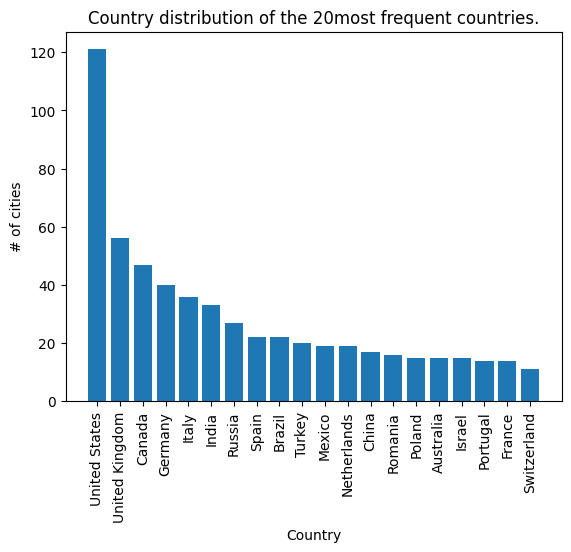

In [75]:
def plot_categorical_hist(categorical, limit=0):
    """
    Plot a histogram for categoricals with 90° ticks.
    Limit output to the highest 'limit' counts.
    """
    categorical_counts = categorical.value_counts()

    limit = limit if limit != 0 else categorical_counts.shape[0]

    categorical_dict = categorical_counts.iloc[:limit].to_dict()

    fig, ax = plt.subplots(1, 1)
    plt.bar(categorical_dict.keys(), categorical_dict.values())
    ax.tick_params(axis='x', labelrotation=90)

    return ax
# end def


n_countries = 20
str_title = (f'Country distribution of the {n_countries}'
             'most frequent countries.')

ax = plot_categorical_hist(df_quality['country'], limit=n_countries)
ax.set_title(str_title)
ax.set_xlabel('Country')
ax.set_ylabel('# of cities')

Looks like cities in the US and European cities are highly present in this dataset.

This raises the question, which continents the cities are located on.

In [76]:
def convert_country_to_continent(country_name):
    """
    Function provides continent name for a country name.
    """

    # initialize continent_name and country_obj
    continent_name = 'Unknown'
    country_obj = []

    # manual fix for 2 countries
    if country_name == 'Ivory Coast':
        country_name = 'Côte d\'Ivoire'

    elif country_name == 'Kosovo (Disputed Territory)':
        country_name = 'Kosovo'

    # end if

    # get the pycountry.Country object
    try:
        country_obj = pycountry.countries.lookup(country_name)

    except LookupError:
        # Print info
        print(('Could not find {} with lookup function. '
               'Trying search_fuzzy.').format(
            country_name
        ))

        # try search fuzzy instead
        try:
            country_list = pycountry.countries.search_fuzzy(country_name)

            # print information whether multiple results occured
            if len(country_list) > 1:
                print(('Expected only one country during '
                       'search_fuzzy, but got {}!.').format(
                    len(country_list)
                ))

            else:
                print('search_fuzzy was successful with exactly one result!')
            # end if

            country_obj = country_list[0]
            print('Using "{}" for "{}".'.format(
                country_obj.name,
                country_name
            ))

        except LookupError:
            print('{} not found. Country will have no continent'.format(
                country_name
            ))

        # end try
    # end try

    if str(type(country_obj)) == \
       "<class 'pycountry.db.Country'>":  # isinstance does not work
        # convert alpha_2 value of country object into continent name
        country_code = country_obj.alpha_2
        continent_code = country_alpha2_to_continent_code(country_code)
        continent_name = convert_continent_code_to_continent_name(
                continent_code
            )
    # end if

    return continent_name
# end def


# add a continen column to the dataset
df_quality['continent'] = df_quality['country'].apply(
        convert_country_to_continent
    )

Text(0, 0.5, '# of cities')

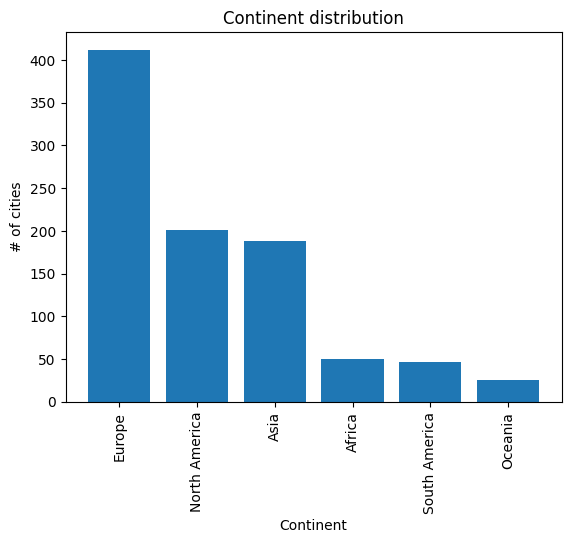

In [77]:
ax = plot_categorical_hist(df_quality['continent'])
ax.set_title('Continent distribution')
ax.set_xlabel('Continent')
ax.set_ylabel('# of cities')

This confirms our first impression: Most of the cities are in Europe and Nothern America. Unknown refers to countries, where the continent could not be automatically assigned.

Let's look at the other distributions

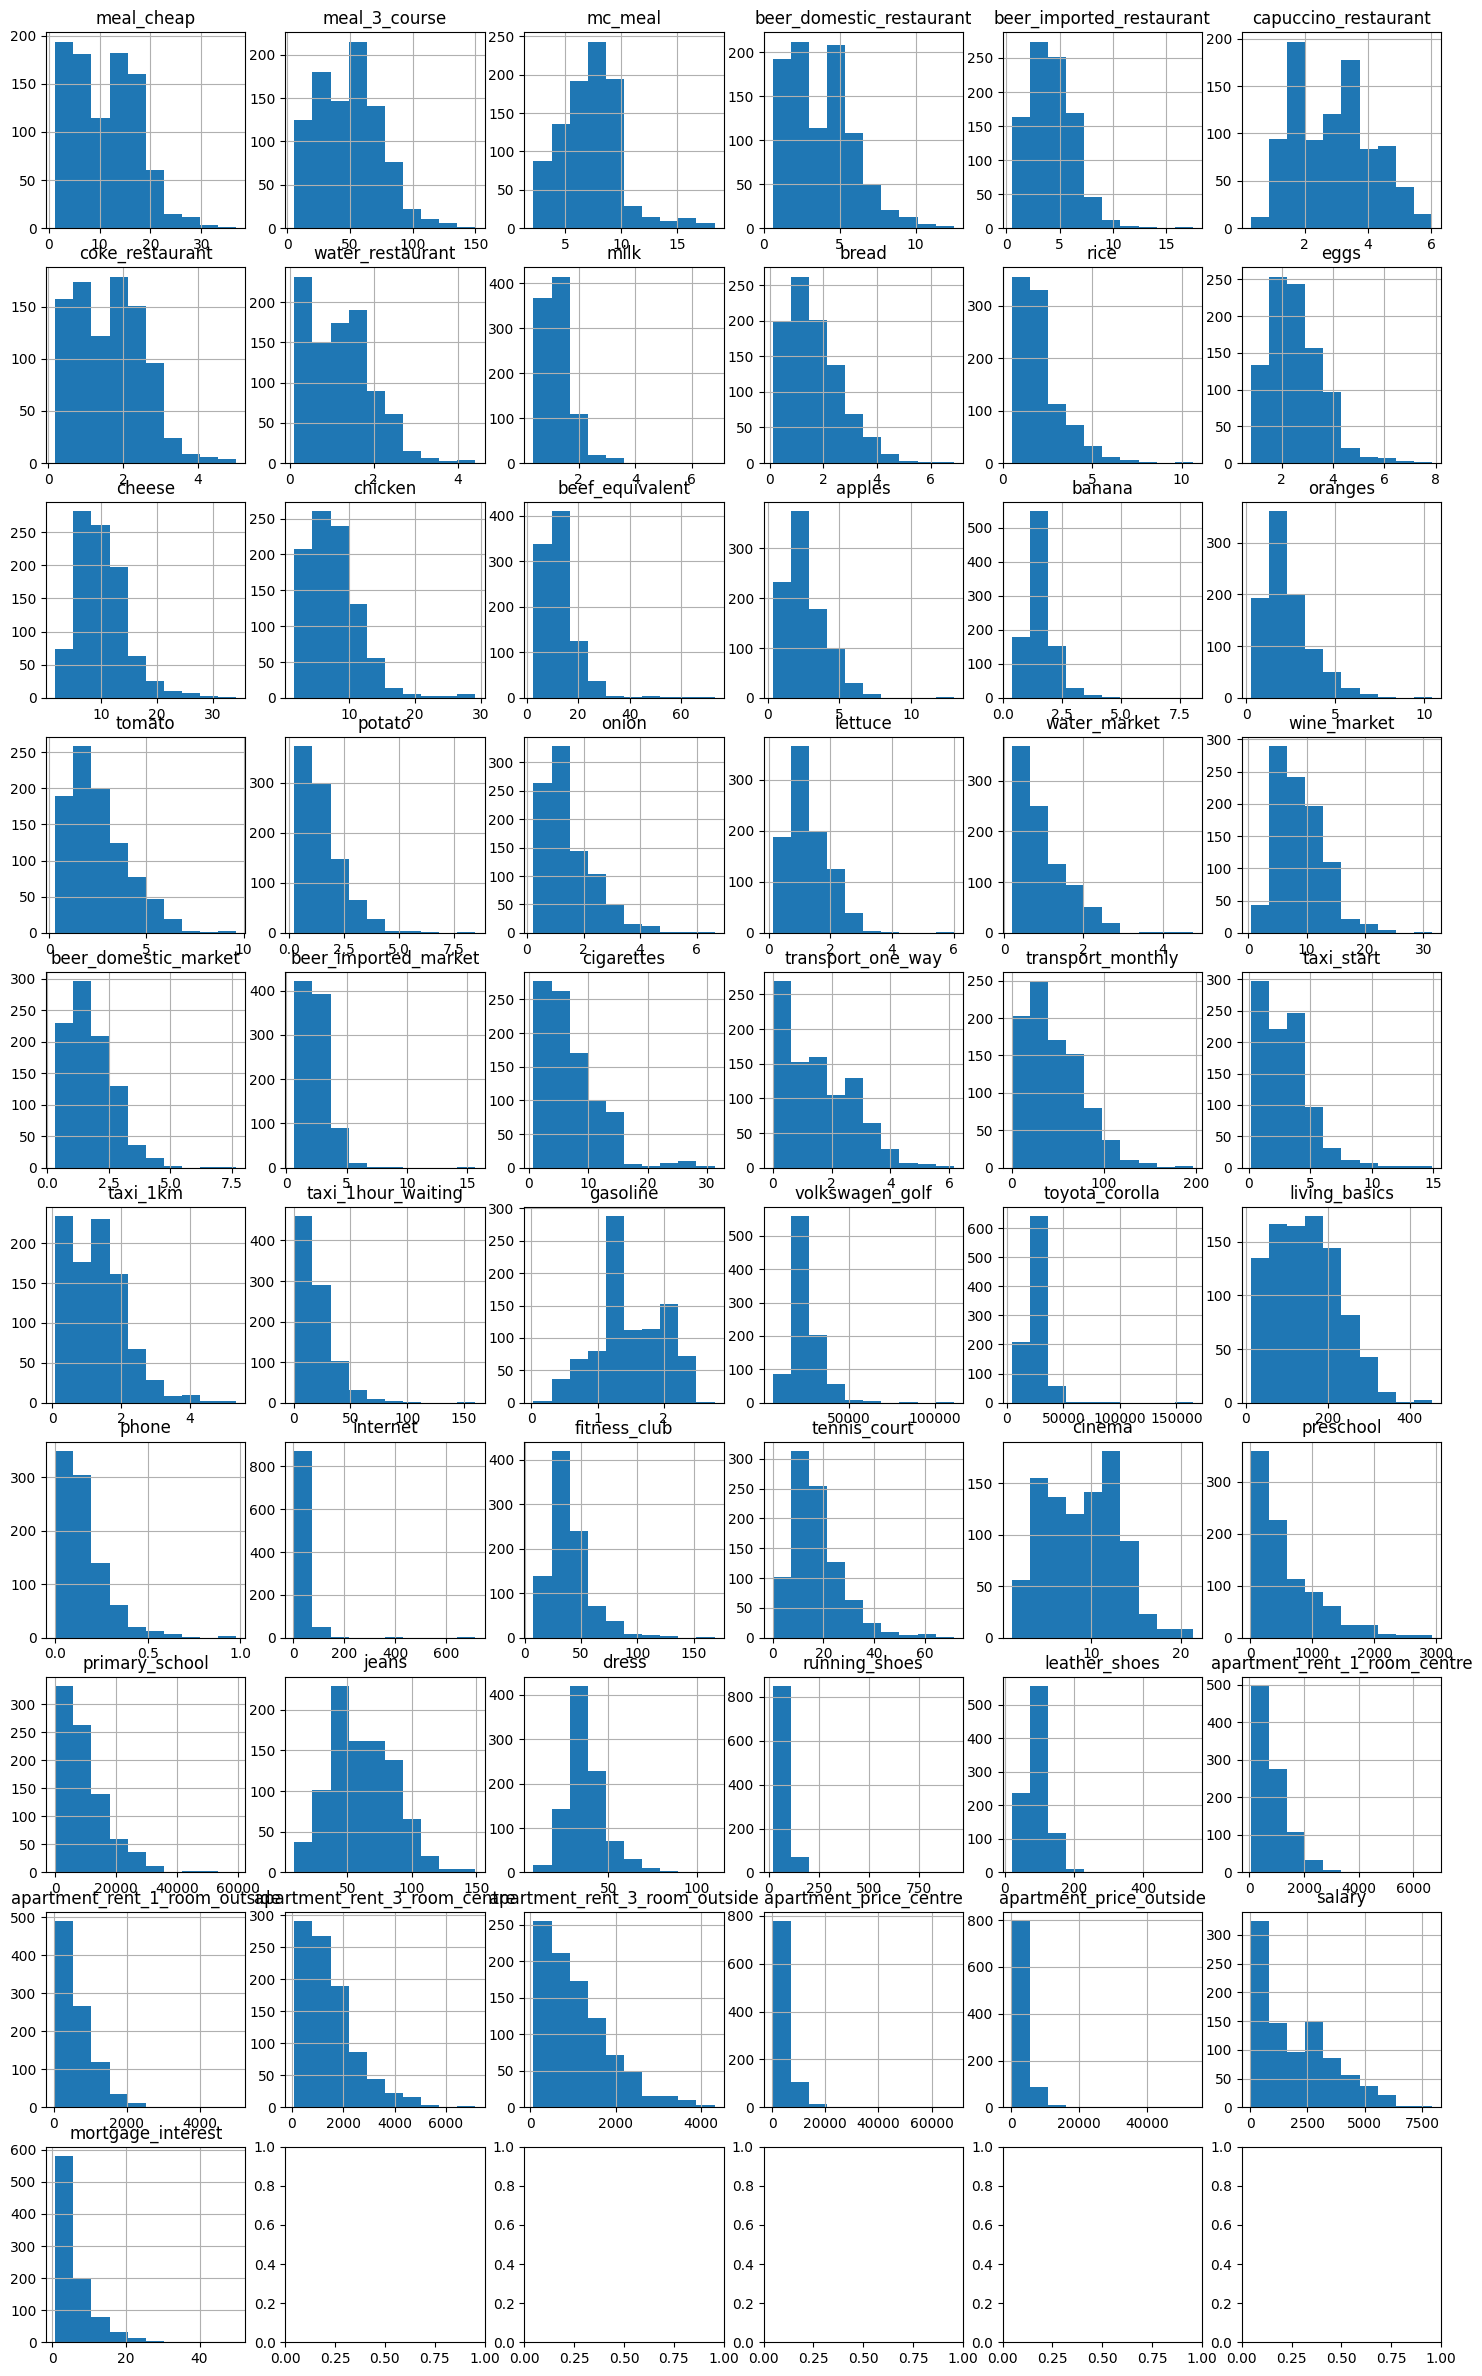

In [78]:
df_hist = df_quality.select_dtypes(include='float')
n_plots = df_hist.shape[1]
n_cols = 6
n_rows = int(np.ceil(n_plots / n_cols))
fig, ax = plt.subplots(
    n_rows,
    n_cols,
    squeeze=True,
    figsize=(3*n_cols, 3*n_rows)
)
ax.resize((ax.size,))

for i in range(n_plots):
    df_hist.iloc[:, i].hist(ax=ax[i])
    ax[i].set_title(df_hist.columns[i])
# end for

We can also draw a heatmap of the correlation values.

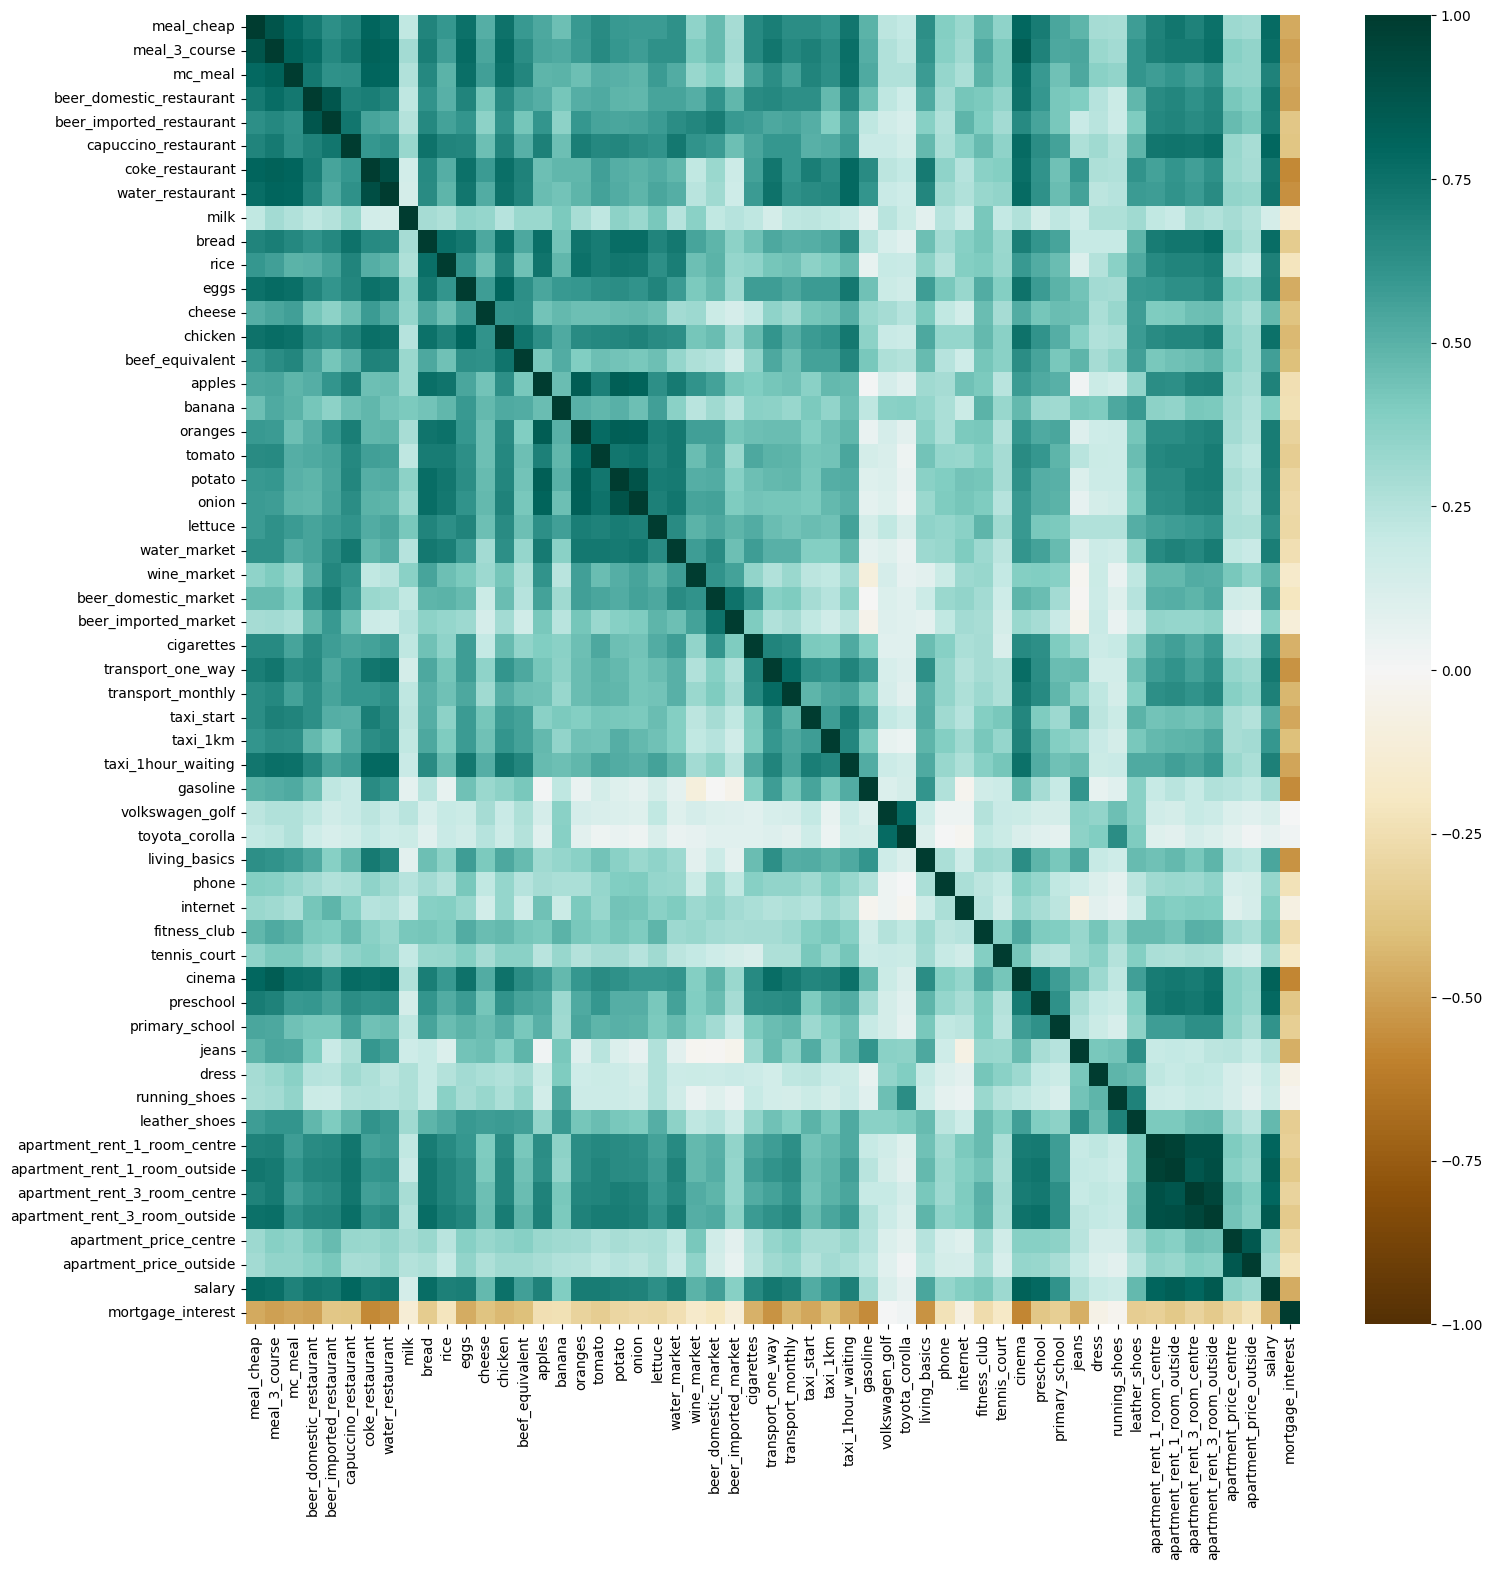

In [79]:
# correlation heatmap
plt.figure(figsize=(17, 17))
sns.heatmap(
    df_hist.corr(numeric_only=True),
    annot=False,
    cmap='BrBG',
    vmin=-1,
    vmax=1
)
plt.show()

This shows how highly correlated the numerical columns in the dataset are.

We can see that appartment rents are highly correlated. 
This means: the higher the rents for 1-room apartments in the city centre are, the higher the rents outside city centre and for 3-room apartments.
Interestingly the buying prices do not show the same high correlation with rents.

## Further Analysis

Let's see where the rental prices for apartments are the highest!

In [80]:
cols = [
    'country',
    'apartment_rent_1_room_centre',
    'apartment_rent_1_room_outside',
    'apartment_rent_3_room_centre',
    'apartment_rent_3_room_outside',
    'apartment_price_centre',
    'apartment_price_outside',
]
print('Are there na values in the analyzed columns? {}'.format(
    na_check(df_quality, cols)
))

# drop the rows with na values
df_apartment_prices = df_quality.loc[:, cols].dropna(axis=0, how='any')

# mean apartment prices and rent grouped by country
mean_apartment_prices = df_apartment_prices.groupby('country').mean()
mean_apartment_prices.head()

# Which countries are in the Top 15 for all categories
n_largest = 15
countries_high_prices = set(mean_apartment_prices.index)
for col in cols[1:]:
    countries_high_prices = (
        countries_high_prices &
        set(mean_apartment_prices.nlargest(n_largest, col).index)
    )
# end for
print(sorted(countries_high_prices))

Looks like 6 countries are amoung the most expensive apartments in all categories!

Let's do some plots to compare the countries with the rest!

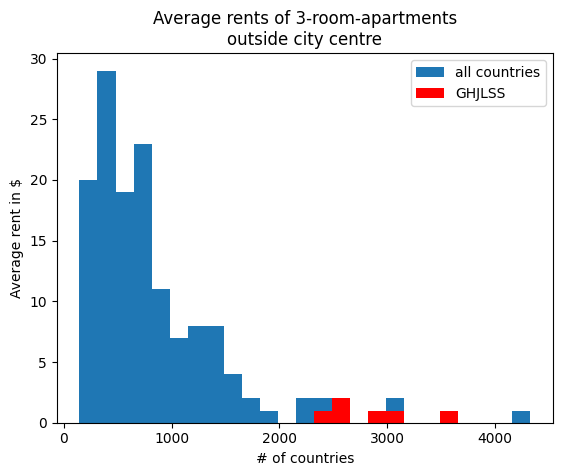

In [81]:
# ### create and save histogram ###

fig, ax = plt.subplots(1, 1)

# choose and print out column
hist_col = cols[4]
print(hist_col)

# define save name and legend labels
save_name = 'fig\\hist_{}'.format(hist_col)
label_1 = 'all countries'
label_2 = 'GHJLSS'

# get data for histogram 1
y_1 = mean_apartment_prices.loc[:, hist_col]

# get data for histogram 2
idx_high_prices = mean_apartment_prices.index.isin(countries_high_prices)
y_2 = mean_apartment_prices.loc[idx_high_prices, hist_col]

# plot histogram 1
hist_1 = plt.hist(
    y_1,
    bins=25,
    label=label_1
)

# plot histogram 2
hist_2 = plt.hist(
    y_2,
    bins=hist_1[1],
    color='red',
    label=label_2
)

# set title and axes labels
ax.set_title('Average rents of 3-room-apartments\noutside city centre')
ax.set_xlabel('# of countries')
ax.set_ylabel('Average rent in $')

# create legend
ax.legend()

# update and save figure
plt.savefig(save_name)
plt.show()

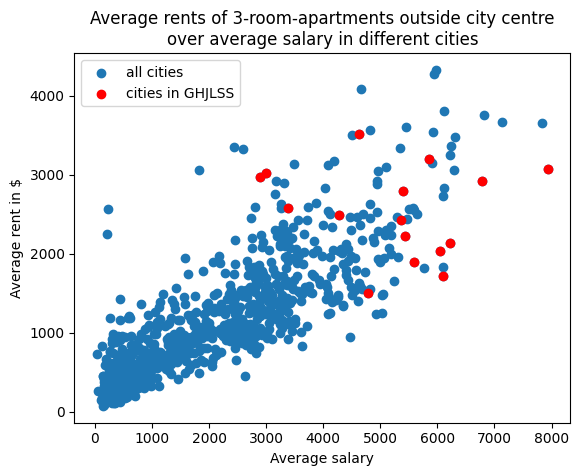

In [82]:
# ### create and save scatter plot ###

# get the relevant columns
scatter_data = df_quality.loc[:, ['salary', hist_col]]

# define save name and legend labels
save_name = 'fig\\scatter_{}'.format(hist_col)
label_1 = 'all cities'
label_2 = 'cities in GHJLSS'

# get data for scatter plot 1
x_1 = scatter_data.iloc[:, 0]
y_1 = scatter_data.iloc[:, 1]

# get data for scatter plot 2
idx_high_prices = df_quality.loc[:, 'country'].isin(countries_high_prices)
x_2 = scatter_data.loc[idx_high_prices].iloc[:, 0]
y_2 = scatter_data.loc[idx_high_prices].iloc[:, 1]

# create figure
fig, ax = plt.subplots(1, 1)

# scatter plot 1
ax.scatter(
    x_1,
    y_1,
    label=label_1
)

# scatter plot 2
ax.scatter(
    x_2,
    y_2,
    c=['#ff0000'],
    label=label_2
)

# set title and axes labels
ax.set_title(('Average rents of 3-room-apartments outside city centre'
              '\nover average salary in different cities'))
ax.set_xlabel('Average salary')
ax.set_ylabel('Average rent in $')

# create legend
ax.legend()

# update and save figure
plt.savefig(save_name)
plt.show()

We can see a strong linear correlation between salary and the rental prices of 3-room-apartments outside city centres. The 6 countries have medium to very high salaries. Interestingly the highest salary in the data set is included in the 6 countries.


# Data Preparation

We now want to create a model to precict the salary based on the other features.
For this we need to clean the data.

Later we want to execute a grid search on some influence factors, which is why we will implement it in a pipeline.

For the na values in the data and handling categorical values, two new transformers where created.
Those are used in the pipeline.

In [83]:
# generate pipeline
pipe = Pipeline([
    # 1 preprocessing
    ('preprocessing', FeatureUnion([
        # .1 handle categoricals
        ('categorical_pipe', Pipeline([
            # .1 drop continent columns or not
            ('drop_cat_cols', CategoricalTransformer()),
            # .2 one-hot-encoding
            ('one_hot', OneHotEncoder(sparse_output=False,
                                      handle_unknown='infrequent_if_exist'))
        ])),
        # .2 handle numericals
        ('numerical_pipe', Pipeline([
            # .1 handle na values
            ('num_na_handling', NumericalTransformer()),
            # .2 polynomial features only for numericals
            ('polynomial', PolynomialFeatures())
        ]))
    ])),
    # 2 choose a standardizer
    ('scaler', StandardScaler()),  # might be changed in the grid search
    # 3 model kind
    ('model', LassoCV())  # might be changed in the grid search
])

In [84]:
# print out the pipeline parameters
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'scaler', 'model', 'preprocessing__n_jobs', 'preprocessing__transformer_list', 'preprocessing__transformer_weights', 'preprocessing__verbose', 'preprocessing__categorical_pipe', 'preprocessing__numerical_pipe', 'preprocessing__categorical_pipe__memory', 'preprocessing__categorical_pipe__steps', 'preprocessing__categorical_pipe__verbose', 'preprocessing__categorical_pipe__drop_cat_cols', 'preprocessing__categorical_pipe__one_hot', 'preprocessing__categorical_pipe__drop_cat_cols__b_drop_continent', 'preprocessing__categorical_pipe__one_hot__categories', 'preprocessing__categorical_pipe__one_hot__drop', 'preprocessing__categorical_pipe__one_hot__dtype', 'preprocessing__categorical_pipe__one_hot__handle_unknown', 'preprocessing__categorical_pipe__one_hot__max_categories', 'preprocessing__categorical_pipe__one_hot__min_frequency', 'preprocessing__categorical_pipe__one_hot__sparse', 'preprocessing__categorical_pipe__one_hot__sparse_ou

In [85]:
# define parameters for grid search
params = {
    # # min frequency of categories for one-hot-encoding
    # 'preprocessing__categorical_pipe__one_hot__min_frequency': [10],
    # max number of categories for one-hot-encoding  # list(range(85, 115)),
    'preprocessing__categorical_pipe__one_hot__max_categories':
        list(range(90, 100)),
    # drop continent column
    'preprocessing__categorical_pipe__drop_cat_cols__b_drop_continent':
        [False],
    # impute method,
    'preprocessing__numerical_pipe__num_na_handling__impute_method':
        ['mean'],  # 'median',
    # max_na_share
    'preprocessing__numerical_pipe__num_na_handling__max_na_share':
        [1],
    # polynomial degree
    'preprocessing__numerical_pipe__polynomial__degree':
        [1],
    # scaler
    'scaler':
        [StandardScaler()],
        # , Normalizer(), QuantileTransformer(), PowerTransformer()],
    # model
    'model':
        [LassoCV(tol=1e-2)],  # , LinearRegression()]
}

# create grid search
grid = GridSearchCV(pipe, param_grid=params)

In [86]:
col_target = 'salary'
# drop the na values in salary
df_quality = df_quality.dropna(axis=0, subset=col_target)

# drop cities column
try:
    df_quality = df_quality.drop('city', axis=1)
except KeyError:  # if city column is already removed
    pass
# end try

X = df_quality.drop(col_target, axis=1)
y = df_quality.loc[:, col_target]

# fit grid serach
grid.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        FeatureUnion(transformer_list=[('categorical_pipe',
                                                                        Pipeline(steps=[('drop_cat_cols',
                                                                                         CategoricalTransformer()),
                                                                                        ('one_hot',
                                                                                         OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                       sparse_output=False))])),
                                                                       ('numerical_pipe',
                                                                        Pipeline(steps=[('num_na_handling',
                                                                                         NumericalTransformer()),
                                                                                        ('polynomial',
                                                                                         Polyno...
                         'preprocessing__categorical_pipe__drop_cat_cols__b_drop_continent': [False],
                         'preprocessing__categorical_pipe__one_hot__max_categories': [90,
                                                                                      91,
                                                                                      92,
                                                                                      93,
                                                                                      94,
                                                                                      95,
                                                                                      96,
                                                                                      97,
                                                                                      98,
                                                                                      99],
                         'preprocessing__numerical_pipe__num_na_handling__impute_method': ['mean'],
                         'preprocessing__numerical_pipe__num_na_handling__max_na_share': [1],
                         'preprocessing__numerical_pipe__polynomial__degree': [1],
                         'scaler': [StandardScaler()]})

In [87]:
# print out the best pipeline parameter combination and the score
print(grid.best_params_)
print(grid.best_score_)

(0.87, 0.89)

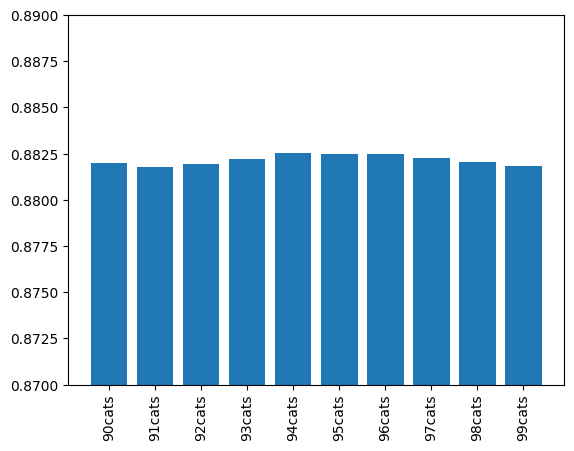

In [88]:
# create a bar plot for the mean test score over the number of categories
mean_score = grid.cv_results_['mean_test_score']
max_cat = grid.cv_results_[
    'param_preprocessing__categorical_pipe__one_hot__max_categories'
]
tick_label = ['{}cats'.format(x) for x in max_cat]

x = range(len(mean_score))

fig, ax = plt.subplots()
ax.bar(x, mean_score)
ax.set_xticks(x)
ax.set_xticklabels(tick_label)
ax.tick_params(axis='x', labelrotation=90)

ax.set_ylim(bottom=.87, top=.89)

Let's train the final model once again with a fixed test and train set.


In [89]:
# test_train_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.3,
    random_state=global_random_state
)

# build pipeline
final_pipe = grid.best_estimator_

# fit model
final_pipe.fit(X_train, y_train)

# print out train and test score
train_score = final_pipe.score(X_train, y_train)
test_score = final_pipe.score(X_test, y_test)
print('Train score R2 is: {}'. format(
    train_score
))
print('Test score R2 is: {}'. format(
    test_score
))

In [90]:
# predictions on the train and test set
y_train_pred = final_pipe.predict(X_train)
y_test_pred = final_pipe.predict(X_test)

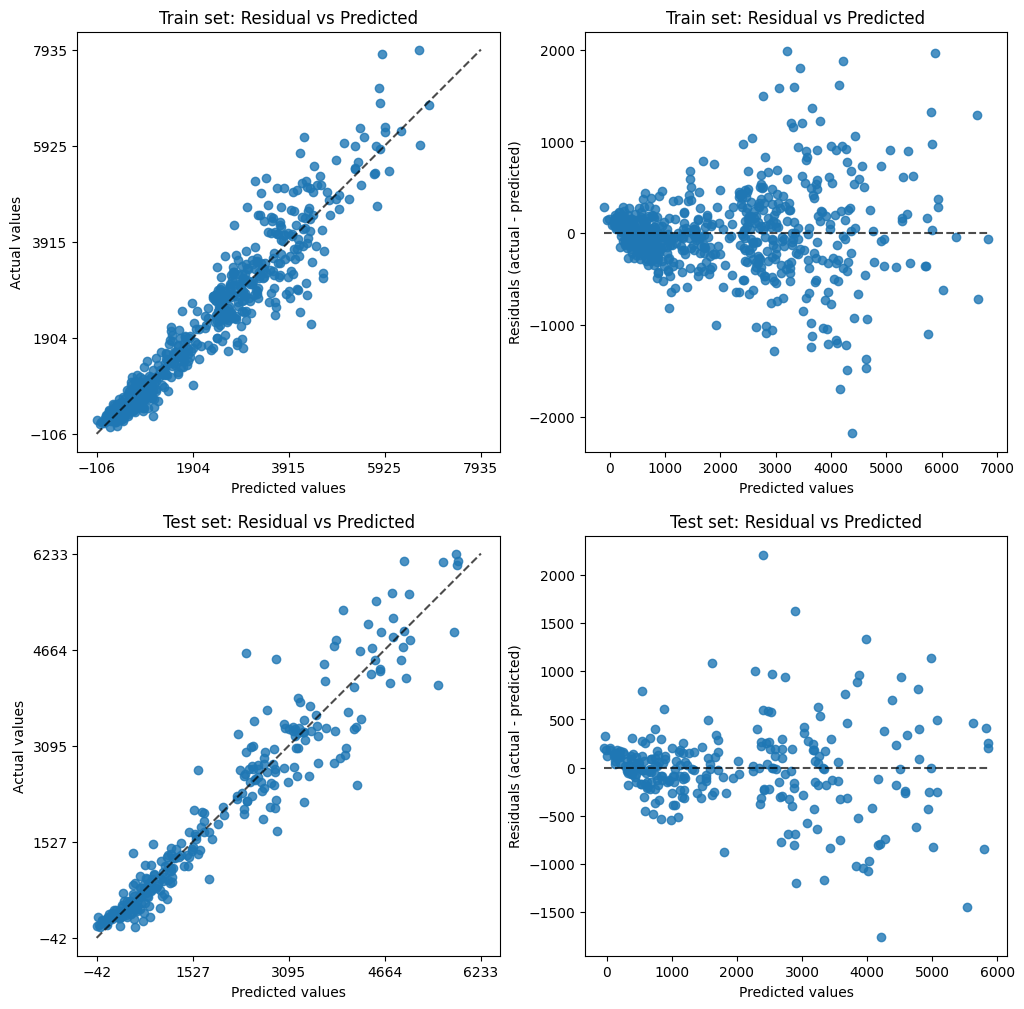

In [91]:
# plot true vs. predicted value
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))


def custom_error_plot(ax, plot_train, plot_residual):
    """
    Function plots an arror plot in axis ax depending on the inputs:
      - plot_train: bool, use train or test error
      - plot_residual: bool, plot 'residual_vs_predicted' or
        'actual_vs_predicted'
    """
    if plot_train:
        test_train_str = 'Train'
        y = y_train
        y_pred = y_train_pred

    else:
        test_train_str = 'Test'
        y = y_test
        y_pred = y_test_pred
    # end if

    if plot_residual:
        kind_str = 'residual_vs_predicted'
        title_kind_str = 'Residual vs Predicted'

    else:
        kind_str = 'actual_vs_predicted'
        title_kind_str = 'Residual vs Predicted'
    # end if

    title_str = '{} set: {}'.format(
        test_train_str,
        title_kind_str
    )

    # set axis title
    ax.set_title(title_str)

    _ = PredictionErrorDisplay.from_predictions(
        y,
        y_pred,
        kind=kind_str,
        ax=ax,
        subsample=None
    )

    return
# end def


# ### Figures with the train set ###
# actual vs predicted
custom_error_plot(axs[0][0], plot_train=True, plot_residual=False)

# residual vs predicted
custom_error_plot(axs[0][1], plot_train=True, plot_residual=True)

# ### Figures with the test set ###
# actual vs predicted
custom_error_plot(axs[1][0], plot_train=False, plot_residual=False)

# residual vs predicted
custom_error_plot(axs[1][1], plot_train=False, plot_residual=True)

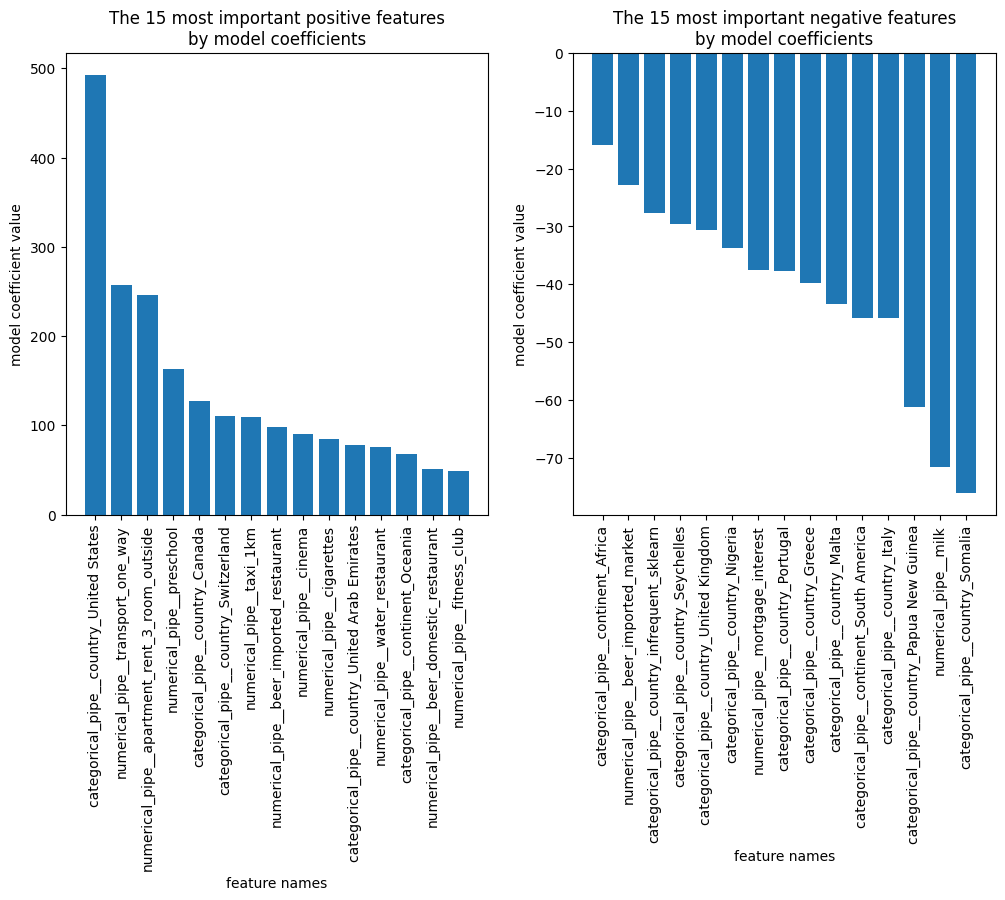

In [92]:
# get feature importance and names
final_model = final_pipe.named_steps['model']
model_coefs = final_model.coef_
importance = np.abs(model_coefs)
feature_names = final_pipe.named_steps['preprocessing'].get_feature_names_out()

# quick sanity check
print('Number of features: {}'.format(len(feature_names)))
print('Number of coefficients: {}'.format(len(model_coefs)))

# sort feature names and importance by descending importance
idx_sort = model_coefs.argsort()
model_coefs_sorted = np.flip(model_coefs[idx_sort])
feature_names_sorted = np.flip(feature_names[idx_sort])

n_bars = 15  # plot only n_bars bars

# create figure
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# common axes label names
xlabel = 'feature names'
ylabel = 'model coefficient value'

# bar plot 1
ax[0].bar(height=model_coefs_sorted[:n_bars], x=feature_names_sorted[:n_bars])
ax[0].set_title(("The {} most important positive features\n"
                 "by model coefficients").format(n_bars))
ax[0].set_xlabel(xlabel)
ax[0].set_ylabel(ylabel)
ax[0].tick_params(axis='x', labelrotation=90)

# bar plot 2
ax[1].bar(height=model_coefs_sorted[-n_bars:],
          x=feature_names_sorted[-n_bars:])
ax[1].set_title(("The {} most important negative features\n"
                 "by model coefficients").format(n_bars))
ax[1].set_xlabel(xlabel)
ax[1].set_ylabel(ylabel)
ax[1].tick_params(axis='x', labelrotation=90)

# update and save figure
plt.savefig(
    r'fig\bar_features',
    bbox_inches="tight"
)
plt.show()

There are a lot of countries or continents in the most important features.
However some other factors seems to play an important role as well.

E.g. public transport, taxi costs and the costs of milk.

Below, I want to check whether the results are plausible in the model and the features are not messed up.

In [93]:
# input to test the milk component
df_milk = df_quality.mode().iloc[0, :].to_frame().T
df_milk = df_milk.convert_dtypes(convert_string=False)
df_milk = pd.concat([df_milk]*2)
df_milk = df_milk.set_index(pd.Index(['min', 'max']))
df_milk.loc['min', 'milk'] = df_quality.loc[:, 'milk'].min()
df_milk.loc['max', 'milk'] = df_quality.loc[:, 'milk'].max()

df_milk = df_milk.loc[:, X_train.columns]
print(df_milk.loc[:, 'milk'])
final_pipe.predict(df_milk)
# final_pipe.predict(X_test.iloc[0,:].to_frame().T.convert_dtypes(convert_string=False))

array([3483.87880168, 2644.58493134])